In [0]:
9# Import the dependencies
import tensorflow as tf
 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras

import gc
gc.enable()
 
print(tf.__version__)

2.2.0


In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# # you do not need to run this cell if you have an access to google drive.
# # download the dataset.
# !wget http://download.cs.stanford.edu/deep/MRNet-v1.0.zip
# # unzip the dataset to google drive.
# !unzip MRNet-v1.0.zip -d /content/drive/My\ Drive/MRNET\ for\ Knee\ Diagnosis/tmp

--2020-06-02 21:06:04--  http://download.cs.stanford.edu/deep/MRNet-v1.0.zip
Resolving download.cs.stanford.edu (download.cs.stanford.edu)... 171.64.64.22
Connecting to download.cs.stanford.edu (download.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6087523606 (5.7G) [application/zip]
Saving to: ‘MRNet-v1.0.zip’

MRNet-v1.0.zip      100%[===================>]   5.67G  1.95MB/s    in 48m 2s  

2020-06-02 21:54:07 (2.01 MB/s) - ‘MRNet-v1.0.zip’ saved [6087523606/6087523606]



In [0]:
# class to load the dataset
# and create 3 generators
# 1) train generator : it will generate the train dataset samples to train the model.
# 2) valid generator : it will generate the validation dataset samples to validate the model during the training.
# 3) test generator  : it will generate the train dataset samples to test the model after training.
class DataLoader():
  #root_dir : the path of the root dirctory of the dataset.
  #task : the task of the classifier (acl, meniscus or abnormal).
  #plane : the type of the image (sagittal, coronal or axial).
  # train_ratio : the ratio to split the dataset to train and validation.
  def __init__(self, root_dir, task, plane, train_ratio = 0.9, oversampling= False, shuffle = True):
    self.root_dir = root_dir
    self.task = task
    self.plane = plane
    self.train_ratio = train_ratio
    #augmentor to apply data augmentation
    self.augmentor = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=25,          # random rotation with range[-25, 25] degree. 
    width_shift_range=25,    # random shifting between –25 and 25 pixels [-25/255, 25/255]
    height_shift_range=25,
    horizontal_flip=True        # random flipping horizontally with 50% probability
    )
 
    self.csv_train = pd.read_csv(root_dir+'/train-{0}.csv'.format(task), header = None, names = ['id', 'label'], 
                                 dtype={'id': str, 'label': np.int8})
    self.csv_test = pd.read_csv(root_dir+'/valid-{0}.csv'.format(task), header = None, names = ['id', 'label'], 
                                 dtype={'id': str, 'label': np.int8})                           
 
    self.csv_train['id'] = self.csv_train['id'].map(lambda i : '0'*(4-len(str(i))) + str(i)) #padding with 0's
    self.csv_test['id'] = self.csv_test['id'].map(lambda i : '0'*(4-len(str(i))) + str(i)) #padding with 0's
 
    #define the class weights to overcome the imbalanced dataset.
    self.neg, self.pos = np.bincount(self.csv_train['label']) + np.bincount(self.csv_test['label'])
    total = self.neg + self.pos
    weight_for_0 = (1 / self.neg)*(total)/2.0 
    weight_for_1 = (1 / self.pos)*(total)/2.0
    print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, self.pos, 100 * self.pos / total))
 
    self.class_weight = {0: weight_for_0, 1: weight_for_1}
 
    print("class weights : ", self.class_weight)
 
    #spliting the data with train_ratio
    all_list_IDs = self.csv_train['id'].to_list()
    number_train_samples = int(round(train_ratio*len(all_list_IDs)))
    self.list_IDs_train = all_list_IDs[:number_train_samples]
    self.labels_train = self.csv_train['label'].to_list()[:number_train_samples]
 
    self.list_IDs_valid = all_list_IDs[number_train_samples:]
    self.labels_valid = self.csv_train['label'].to_list()[number_train_samples:]
    #load the images
    all_images = np.load(root_dir+ "/train/" + self.plane +".npy", allow_pickle=True)
 
    self.train_images = all_images[:number_train_samples]
    self.valid_images = all_images[number_train_samples:]
    #create the generators
    self.train_generator = DataGenerator(self.train_images, self.list_IDs_train, self.labels_train, shuffle=shuffle, oversampling= oversampling)
    self.valid_generator = DataGenerator(self.valid_images, self.list_IDs_valid, self.labels_valid, shuffle=shuffle)
 
 
    self.list_IDs_test = self.csv_test['id'].to_list()
    self.labels_test = self.csv_test['label'].to_list()
    self.test_images = np.load(root_dir+ "/valid/" + self.plane +".npy", allow_pickle=True)
 
    self.test_generator = DataGenerator(self.test_images, self.list_IDs_test, self.labels_test)
 
    neg_train, pos_train = np.bincount(self.labels_train)
    print("positive train samples : ", pos_train, " negative train samples : ", neg_train)
    neg_valid, pos_valid = np.bincount(self.labels_valid)
    print("positive valid samples : ", pos_valid, " negative valid samples : ", neg_valid)
    neg_test, pos_test = np.bincount(self.labels_test)
    print("positive test samples : ", pos_test, " negative test samples : ", neg_test)
 
    del all_images
    del all_list_IDs
 
  #return : train generator
  def get_train_generator(self):
    return self.train_generator
 
  #return : validation generator
  def get_valid_generator(self):
    return self.valid_generator
 
  #return : test generator
  def get_test_generator(self):
    return self.test_generator
 
  def get_class_weight(self):
    return self.class_weight
 
  def __del__(self):
    del self.csv_train
    del self.csv_test
    del self.train_generator
    del self.valid_generator
    del self.test_generator

In [0]:
INPUT_DIM = 224
MAX_PIXEL_VAL = 255
MEAN = 58.09
STDDEV = 49.73
 
# class to generate the samples
class DataGenerator(keras.utils.Sequence):
  # images : the list of images as numpy array
  # list_IDs : the list of ids of each image
  # labels : the list of labels of each image [0, 1]
  # augmentor : the augmentor to apply data augmentation [only in traing dataset]
  # batch_size : the batch size to generate (default 1)
  # shuffle : booelan to make the generator shuffle the dataset after each epoch or not.
  def __init__(self, images, list_IDs, labels, augmentor = None, batch_size=1, shuffle=False, oversampling= False):
    self.list_IDs = np.array(list_IDs)
    if oversampling == True:
        self.overSampling(labels)
    self.labels = dict(zip(list_IDs, labels))
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.indexes = np.arange(len(self.list_IDs))
    self.images = dict(zip(list_IDs, images))
    self.augmentor = augmentor
    self.on_epoch_end()
    # neg = np.mean(labels)
    # self.weights = [neg*100, (1-neg)*100]
    del images
 
  def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
 
  def __len__(self):
    return int(np.floor(len(self.list_IDs) / self.batch_size))
 
  def __getitem__(self, index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    list_IDs_temp = [self.list_IDs[k] for k in indexes]
 
    X, y= self.__data_generation(list_IDs_temp)
 
    return X, y
 
  def __data_generation(self, list_IDs_temp):
    X = []
    Y = np.empty((self.batch_size, 1), dtype=np.int64)
    # W = np.empty((self.batch_size, 1), dtype=np.int64)
    
    for i, ID in enumerate(list_IDs_temp):
      image = self.images[ID]
      image= self.normalize_image(image)      
      image_rgb = np.stack((image,)*3, axis=3)
      if self.augmentor == None :    
       X.append(image_rgb)
      else :
        image_augmented = next(self.augmentor.flow(image_rgb, batch_size= image_rgb.shape[0]))
        X.append(image_augmented)
        del image_augmented
 
      del image_rgb
      del image
      Y[i] = self.labels[ID]
    
    X_batched  = np.squeeze(X, axis=0)
    del X
    return X_batched, Y
    
  def __del__(self):
    del self.images
    del self.list_IDs
    del self.labels
    del self.indexes
    
 
  def overSampling(self, labels):
    labels = np.array(labels)
    ids_neg = self.list_IDs[labels == 0]
    ids_pos = self.list_IDs[labels == 1]
    choices = np.random.choice(np.arange(len(ids_pos)), len(ids_neg))
 
    self.list_IDs = np.concatenate([ids_pos[choices], ids_neg], axis=0)
    del ids_neg
    del ids_pos
    del choices
 
  def normalize_image(self, image):
    pad = int((image.shape[2]- INPUT_DIM)/2)
    padded_image = image[:, pad:-pad, pad:-pad]
    standardized_image = (padded_image - np.min(padded_image)) / (np.max(padded_image) - np.min(padded_image)) * MAX_PIXEL_VAL
    normalized_image = (standardized_image - MEAN) / STDDEV
 
    del padded_image
    del standardized_image
 
    return normalized_image

In [0]:
# root_dir = "/content/drive/My Drive/MRNET for Knee Diagnosis/MRNet-v1.0"
# task = "acl"
# plane = "sagittal"
# dataLoader = DataLoader(root_dir, task, plane)

Examples:
    Total: 1250
    Positive: 262 (20.96% of total)

class weights :  {0: 0.6325910931174089, 1: 2.3854961832061066}
positive train samples :  191  negative train samples :  826
positive valid samples :  17  negative valid samples :  96
positive test samples :  54  negative test samples :  66


In [0]:
# class_weight = dataLoader.get_class_weight()

# print('Weight for class 0: {:.2f}'.format(class_weight[0]))
# print('Weight for class 1: {:.2f}'.format(class_weight[1]))

Weight for class 0: 0.63
Weight for class 1: 2.39


In [0]:
# train_generator = dataLoader.get_train_generator()

In [0]:
# image, label = train_generator.__getitem__(9)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0]]


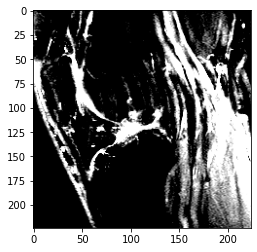

In [0]:
# plt.imshow(image[10])
# print(label)

In [0]:
INPUT_DIM = 224
MAX_PIXEL_VAL = 255
MEAN = 58.09
STDDEV = 49.73
 
# class to generate the samples
class FullDataGenerator(keras.utils.Sequence):
  #root_dir : the path of the root dirctory of the dataset.
  #task : the task of the classifier (acl, meniscus or abnormal).
  # batch_size : the batch size to generate (default 1)
  # shuffle : booelan to make the generator shuffle the dataset after each epoch or not.
  def __init__(self, root_dir, task, plane, train= False):

    self.root_dir = root_dir
    self.task = task
    self.plane = plane
    if train == True :
      self.type = "train"
    else :
      self.type = "valid"
    csv = pd.read_csv(root_dir+'/'+ self.type +'-{0}.csv'.format(task), header = None, names = ['id', 'label'], 
                                 dtype={'id': str, 'label': np.int8})
    csv['id'] = csv['id'].map(lambda i : '0'*(4-len(str(i))) + str(i)) #padding with 0's                        

    self.list_IDs = csv['id'].to_list()
    self.labels = csv['label'].to_list()

    del csv
    gc.collect()
    
  def __len__(self):
    return len(self.labels)
 
  def __getitem__(self, index):
    
    ID = self.list_IDs[index] 
    image =  np.load(self.root_dir+ "/"+ self.type +"/" + self.plane + "/"+ ID +".npy")
    Y = np.empty((1, 1), dtype=np.int8)
    Y[0] = self.labels[index]

    normalized_image = self.normalize_image(image) 

    del image
    gc.collect() 

    return normalized_image, Y
    
  def __del__(self):
    del self.labels
    del self.list_IDs  
 
  def normalize_image(self, image):
    pad = int((image.shape[2]- INPUT_DIM)/2)
    padded_image = image[:, pad:-pad, pad:-pad]
    standardized_image = (padded_image - np.min(padded_image)) / (np.max(padded_image) - np.min(padded_image)) * MAX_PIXEL_VAL
    normalized_image = (standardized_image - MEAN) / STDDEV

    image_rgb = np.stack((normalized_image,)*3, axis=3)
 
    del padded_image
    del standardized_image
    del normalized_image
 
    return image_rgb

In [0]:
# root_dir = "/content/drive/My Drive/MRNET for Knee Diagnosis/tmp/MRNet-v1.0"
# task = "acl"
# trainLoader = FullDataGenerator(root_dir, task, "sagittal", train= True)